In [1]:
import pandas as pd

# -------------------------------
# Load & Initial Inspection
# -------------------------------
patients = pd.read_csv("patients.csv")
print("Shape:", patients.shape)
print("\nColumns:\n", patients.columns.tolist())
print("\nMissing values:\n", patients.isna().sum())
print("\nData types:\n", patients.dtypes)
patients.head()

# -------------------------------
# Drop PII & unused columns
# -------------------------------
drop_cols = [
    "SSN", "DRIVERS", "PASSPORT",
    "PREFIX", "FIRST", "LAST",
    "SUFFIX", "MAIDEN", "ADDRESS"
]
patients = patients.drop(columns=drop_cols, errors="ignore")

# Missing value summary
missing_summary = pd.DataFrame({
    "Missing Count": patients.isnull().sum(),
    "Missing %": patients.isnull().mean() * 100
})
print(missing_summary[missing_summary["Missing Count"] > 0])

# -------------------------------
# Convert and validate date fields
# -------------------------------
patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"], errors="coerce")
patients["DEATHDATE"] = pd.to_datetime(patients["DEATHDATE"], errors="coerce")

print("Invalid BIRTHDATEs:", patients["BIRTHDATE"].isna().sum())
print("Invalid DEATHDATEs:", patients["DEATHDATE"].isna().sum())

today = pd.Timestamp.today()

# Birthdate cannot be in future
mask_future_birth = patients["BIRTHDATE"] > today

# Birthdate cannot be after deathdate
mask_birth_after_death = (
    patients["DEATHDATE"].notna() &
    (patients["BIRTHDATE"] > patients["DEATHDATE"])
)

# Remove implausible records
patients = patients[~(mask_future_birth | mask_birth_after_death)].copy()

# -------------------------------
# Age calculation
# -------------------------------
patients["AGE"] = ((today - patients["BIRTHDATE"]).dt.days // 365)

# Valid age range
patients = patients[(patients["AGE"] >= 0) & (patients["AGE"] <= 110)]

# -------------------------------
# Clean categorical fields
# -------------------------------
cat_cols = ["RACE", "ETHNICITY", "GENDER", "MARITAL", "CITY", "STATE", "COUNTY", "ZIP"]
for col in cat_cols:
    patients[col] = patients[col].fillna("Unknown")

# -------------------------------
# ZIP Cleaning
# -------------------------------
patients["ZIP"] = patients["ZIP"].astype(str)
patients["ZIP"] = patients["ZIP"].str.replace(r"\.0$", "", regex=True)
patients["ZIP"] = patients["ZIP"].apply(lambda x: x.zfill(5) if x.isdigit() else "Unknown")

# -------------------------------
# Deceased flag
# -------------------------------
patients["IS_DECEASED"] = patients["DEATHDATE"].notna().astype(int)

# -------------------------------
# Age groups
# -------------------------------
bins = [0, 5, 17, 35, 55, 110]
labels = ["0-5", "6-17", "18-35", "36-55", "55+"]
patients["AGE_GROUP"] = pd.cut(patients["AGE"], bins=bins, labels=labels, right=True)

# -------------------------------
# Final cleaned copy
# -------------------------------
patients1 = patients.copy()
patients1.head()


Shape: (12352, 25)

Columns:
 ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']

Missing values:
 Id                         0
BIRTHDATE                  0
DEATHDATE              10000
SSN                        0
DRIVERS                 1953
PASSPORT                2507
PREFIX                  2242
FIRST                      0
LAST                       0
SUFFIX                 12228
MAIDEN                  8812
MARITAL                 3519
RACE                       0
ETHNICITY                  0
GENDER                     0
BIRTHPLACE                 0
ADDRESS                    0
CITY                       0
STATE                      0
COUNTY                     0
ZIP                     5652
LAT                        0
LON                        0
HEALTHCARE_EXP

,Id,BIRTHDATE,DEATHDATE,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,AGE,IS_DECEASED,AGE_GROUP
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,2017-08-24,NaT,Unknown,white,nonhispanic,M,Beverly Massachusetts US,Springfield,Massachusetts,Hampden County,01106,42.151961,-72.598959,8446.49,1499.08,8,0,6-17
1,067318a4-db8f-447f-8b6e-f2f61e9baaa5,2016-08-01,NaT,Unknown,white,nonhispanic,F,Boston Massachusetts US,Walpole,Massachusetts,Norfolk County,02081,42.177370,-71.281353,89893.40,1845.72,9,0,6-17
2,ae9efba3-ddc4-43f9-a781-f72019388548,1992-06-30,NaT,S,white,nonhispanic,M,Springfield Massachusetts US,Chicopee,Massachusetts,Hampden County,01020,42.181642,-72.608842,577445.86,3528.84,33,0,18-35
3,199c586f-af16-4091-9998-ee4cfc02ee7a,2004-01-09,NaT,Unknown,white,nonhispanic,F,Worcester Massachusetts US,Pembroke,Massachusetts,Plymouth County,Unknown,42.075292,-70.757035,336701.72,2705.64,21,0,18-35
4,353016ea-a0ff-4154-85bb-1cf8b6cedf20,1996-11-15,NaT,Unknown,white,nonhispanic,M,Patras Achaea GR,Boston,Massachusetts,Suffolk County,02135,42.352434,-71.028610,484076.34,3043.04,29,0,18-35


In [2]:
import pandas as pd

# Load the conditions dataset
conditions = pd.read_csv("conditions.csv")

# -------------------------------
# 1. Convert dates and clean
# -------------------------------
conditions['START'] = pd.to_datetime(conditions['START'], errors='coerce')
conditions['STOP'] = pd.to_datetime(conditions['STOP'], errors='coerce')

today = pd.Timestamp.today()

# Remove rows with missing or future START dates
conditions = conditions[conditions['START'].notna() & (conditions['START'] <= today)]

# Fill missing STOP dates with today
conditions['STOP'] = conditions['STOP'].fillna(today)

# Remove rows where STOP is before START
conditions = conditions[conditions['STOP'] >= conditions['START']]

# Drop duplicates (same patient, same code, same start date)
conditions = conditions.drop_duplicates(subset=['PATIENT', 'CODE', 'START'])

# -------------------------------
# 2. Aggregate patient-level features
# -------------------------------
# Total conditions and first diagnosis date
agg_df = conditions.groupby('PATIENT').agg(
    TOTAL_CONDITIONS=('CODE', 'count'),
    FIRST_DIAG_DATE=('START', 'min')
)

# Years since first diagnosis
agg_df['YEARS_SINCE_FIRST_DIAG'] = ((today - agg_df['FIRST_DIAG_DATE']).dt.days // 365)

# Drop intermediate date column
agg_df = agg_df.drop(columns='FIRST_DIAG_DATE')

# -------------------------------
# 3. Add binary flags for major chronic conditions
# -------------------------------
chronic_keywords = ['diabetes','hypertension','heart','copd','asthma','cancer']

# Create boolean columns for each keyword
for keyword in chronic_keywords:
    conditions[f'{keyword}_FLAG'] = conditions['DESCRIPTION'].str.lower().str.contains(keyword, na=False)

# Aggregate flags by patient (1 if patient has the condition, 0 otherwise)
agg_flags = conditions.groupby('PATIENT')[[f'{k}_FLAG' for k in chronic_keywords]].max().astype(int)

# Merge flags into patient-level dataframe
agg_df = agg_df.merge(agg_flags, left_index=True, right_index=True, how='left')

# Reset index to make PATIENT a column
agg_df = agg_df.reset_index()

# -------------------------------
# 4. Final patient-level dataframe
# -------------------------------
print(agg_df.head())


                                PATIENT  TOTAL_CONDITIONS  \
0  0000b247-1def-417a-a783-41c8682be022                 6   
1  00049ee8-5953-4edd-a277-b9c1b1a7f16b                11   
2  000769a6-23a7-426e-a264-cb0e509b2da2                 4   
3  00079a57-24a8-430f-b4f8-a1cf34f90060                12   
4  0008a63c-c95c-46c2-9ef3-831d68892019                16   

   YEARS_SINCE_FIRST_DIAG  diabetes_FLAG  hypertension_FLAG  heart_FLAG  \
0                       5              0                  0           0   
1                      36              1                  0           0   
2                      35              0                  0           0   
3                      16              0                  1           0   
4                       8              0                  0           0   

   copd_FLAG  asthma_FLAG  cancer_FLAG  
0          0            0            0  
1          0            0            0  
2          0            0            0  
3          0      

In [3]:
import pandas as pd

# Load immunizations dataset
immuns = pd.read_csv("immunizations.csv")
print("Initial shape:", immuns.shape)

# Preview the first few rows
print("\nPreview of dataset:")
print(immuns.head().to_string())

# -------------------------------
# Missing value inspection
# -------------------------------
missing_countsi = immuns.isnull().sum()
missing_percenti = immuns.isnull().mean() * 100

missing_summaryi = pd.DataFrame({
    'Missing Count': missing_countsi,
    'Missing %': missing_percenti
})

missing_summaryi = missing_summaryi[missing_summaryi['Missing Count'] > 0]

print("\nMissing Value Summary:")
print(missing_summaryi)


# -------------------------------
# 1. Convert dates + validate
# -------------------------------
immuns["DATE"] = pd.to_datetime(immuns["DATE"], errors="coerce")
today = pd.Timestamp.today()

# Remove missing or future dates
immuns = immuns[immuns["DATE"].notna() & (immuns["DATE"] <= today)]

# -------------------------------
# 2. Drop duplicates
#    (same patient, same code, same date)
# -------------------------------
immuns = immuns.drop_duplicates(subset=["PATIENT", "CODE", "DATE"])

# -------------------------------
# 3. Clean Description text
# -------------------------------
immuns["DESCRIPTION"] = immuns["DESCRIPTION"].str.lower().str.strip()

# -------------------------------
# 4. Aggregate patient-level features
# -------------------------------

# Total immunizations received
agg_immun = immuns.groupby("PATIENT").agg(
    TOTAL_VACCINES=("CODE", "count"),
    UNIQUE_VACCINES=("CODE", "nunique"),
    FIRST_IMMUN_DATE=("DATE", "min"),
    LAST_IMMUN_DATE=("DATE", "max")
)

# Time since last immunization
agg_immun["DAYS_SINCE_LAST_IMMUN"] = (
    (today - agg_immun["LAST_IMMUN_DATE"]).dt.days
)

# Drop date columns if not needed
agg_immun = agg_immun.drop(columns=["FIRST_IMMUN_DATE", "LAST_IMMUN_DATE"])

# -------------------------------
# 5. Add vaccine category flags
# -------------------------------
vaccine_keywords = {
    "flu": ["flu", "influenza"],
    "covid": ["covid", "sars-cov"],
    "mmr": ["mmr", "measles"],
    "tetanus": ["tdap", "tetanus", "dtap"]
}

# Create flag columns
for vaccine, keywords in vaccine_keywords.items():
    immuns[f"{vaccine.upper()}_FLAG"] = immuns["DESCRIPTION"].str.contains(
        "|".join(keywords), na=False
    ).astype(int)

# Aggregate flags by patient
flag_cols = [col for col in immuns.columns if col.endswith("_FLAG")]

agg_flags = immuns.groupby("PATIENT")[flag_cols].max()

# -------------------------------
# 6. Merge aggregated features
# -------------------------------
immuns_df = agg_immun.merge(agg_flags, left_index=True, right_index=True, how="left")

# Reset index and prepare for joins
immuns_df = immuns_df.reset_index()

print("\nFinal immunization feature set:")
print(immuns_df.head())
print("\nShape:", immuns_df.shape)



Initial shape: (16481, 6)

Preview of dataset:
         DATE                               PATIENT                             ENCOUNTER  CODE                                         DESCRIPTION  BASE_COST
0  2019-08-01  f0f3bc8d-ef38-49ce-a2bd-dfdda982b271  6a74fdef-2287-44bf-b9e7-18012376faca   140  Influenza  seasonal  injectable  preservative free     140.52
1  2020-01-30  f0f3bc8d-ef38-49ce-a2bd-dfdda982b271  821e57ac-9304-46a9-9f9b-83daf60e9e43    83                             Hep A  ped/adol  2 dose     140.52
2  2019-07-08  067318a4-db8f-447f-8b6e-f2f61e9baaa5  9aa748b8-3b44-4e34-b7a8-2e56f2ca3ca2   140  Influenza  seasonal  injectable  preservative free     140.52
3  2019-10-15  ae9efba3-ddc4-43f9-a781-f72019388548  6f9b301a-2b06-4868-b968-4d24faac576b   140  Influenza  seasonal  injectable  preservative free     140.52
4  2020-02-21  199c586f-af16-4091-9998-ee4cfc02ee7a  5844b770-504a-4eb4-a655-8483881dafb1   140  Influenza  seasonal  injectable  preservative free     140.52

In [7]:
# Merge patients with conditions
df = patients1.merge(agg_df, left_on="Id", right_on="PATIENT", how="left")

# Merge patients+conditions with immunizations
df = df.merge(immuns_df, left_on="Id", right_on="PATIENT", how="left")

drop_cols1 = [
    "ZIP"
]
df = df.drop(columns=drop_cols1, errors="ignore")

# Drop duplicate PATIENT columns
df = df.drop(columns=["PATIENT_x", "PATIENT_y"], errors="ignore")

# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)  # Optional: adjust console width

# Print first 5 rows
print(df.head(10))

print("Final merged dataset shape:", df.shape)
print(df.head())


                                     Id  BIRTHDATE DEATHDATE  MARITAL   RACE    ETHNICITY GENDER                        BIRTHPLACE         CITY          STATE            COUNTY        LAT  \
0  f0f3bc8d-ef38-49ce-a2bd-dfdda982b271 2017-08-24       NaT  Unknown  white  nonhispanic      M        Beverly  Massachusetts  US  Springfield  Massachusetts    Hampden County  42.151961   
1  067318a4-db8f-447f-8b6e-f2f61e9baaa5 2016-08-01       NaT  Unknown  white  nonhispanic      F         Boston  Massachusetts  US      Walpole  Massachusetts    Norfolk County  42.177370   
2  ae9efba3-ddc4-43f9-a781-f72019388548 1992-06-30       NaT        S  white  nonhispanic      M    Springfield  Massachusetts  US     Chicopee  Massachusetts    Hampden County  42.181642   
3  199c586f-af16-4091-9998-ee4cfc02ee7a 2004-01-09       NaT  Unknown  white  nonhispanic      F      Worcester  Massachusetts  US     Pembroke  Massachusetts   Plymouth County  42.075292   
4  353016ea-a0ff-4154-85bb-1cf8b6cedf20 1996-

In [8]:
# List of numeric columns for vaccines and conditions
numeric_cols = [
    'TOTAL_CONDITIONS', 'YEARS_SINCE_FIRST_DIAG',
    'diabetes_FLAG', 'hypertension_FLAG', 'heart_FLAG', 'copd_FLAG', 'asthma_FLAG', 'cancer_FLAG',
    'TOTAL_VACCINES', 'UNIQUE_VACCINES', 'DAYS_SINCE_LAST_IMMUN',
    'FLU_FLAG', 'COVID_FLAG', 'MMR_FLAG', 'TETANUS_FLAG'
]


df[numeric_cols] = df[numeric_cols].fillna(0)

# Select categorical columns
categorical_cols = ['GENDER', 'RACE', 'ETHNICITY', 'MARITAL', 'AGE_GROUP', 'STATE']

# Fill missing with 'Unknown' (if any)
for col in categorical_cols:
    df[col] = df[col].astype('category')
    if 'unknown' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('unknown')
    df[col] = df[col].fillna('unknown')


# One-hot encode categorical variables
finadataframe_s1 = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

finadataframe_s1['memberid'] = finadataframe_s1['Id'].str[:8]
drop_cols = ['Id', 'BIRTHDATE', 'DEATHDATE', 'BIRTHPLACE', 'CITY', 'COUNTY']
finadataframe_s1 = finadataframe_s1.drop(columns=[c for c in drop_cols if c in finadataframe_s1.columns])

print("Final dataset ready for modeling:")
print(finadataframe_s1.head(10))
print("Shape:", finadataframe_s1.shape)

Final dataset ready for modeling:
         LAT        LON  HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE  AGE  IS_DECEASED  TOTAL_CONDITIONS  YEARS_SINCE_FIRST_DIAG  diabetes_FLAG  hypertension_FLAG  heart_FLAG  copd_FLAG  asthma_FLAG  \
0  42.151961 -72.598959              8446.49              1499.08    8            0               5.0                     6.0            0.0                0.0         0.0        0.0          0.0   
1  42.177370 -71.281353             89893.40              1845.72    9            0               8.0                     5.0            0.0                0.0         0.0        0.0          0.0   
2  42.181642 -72.608842            577445.86              3528.84   33            0              11.0                    15.0            0.0                1.0         0.0        0.0          0.0   
3  42.075292 -70.757035            336701.72              2705.64   21            0               7.0                     5.0            0.0                0.0         0.

In [9]:
# To convert the column names to a list
print(list(df.columns))


['Id', 'BIRTHDATE', 'DEATHDATE', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE', 'COUNTY', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'AGE', 'IS_DECEASED', 'AGE_GROUP', 'TOTAL_CONDITIONS', 'YEARS_SINCE_FIRST_DIAG', 'diabetes_FLAG', 'hypertension_FLAG', 'heart_FLAG', 'copd_FLAG', 'asthma_FLAG', 'cancer_FLAG', 'TOTAL_VACCINES', 'UNIQUE_VACCINES', 'DAYS_SINCE_LAST_IMMUN', 'FLU_FLAG', 'COVID_FLAG', 'MMR_FLAG', 'TETANUS_FLAG']


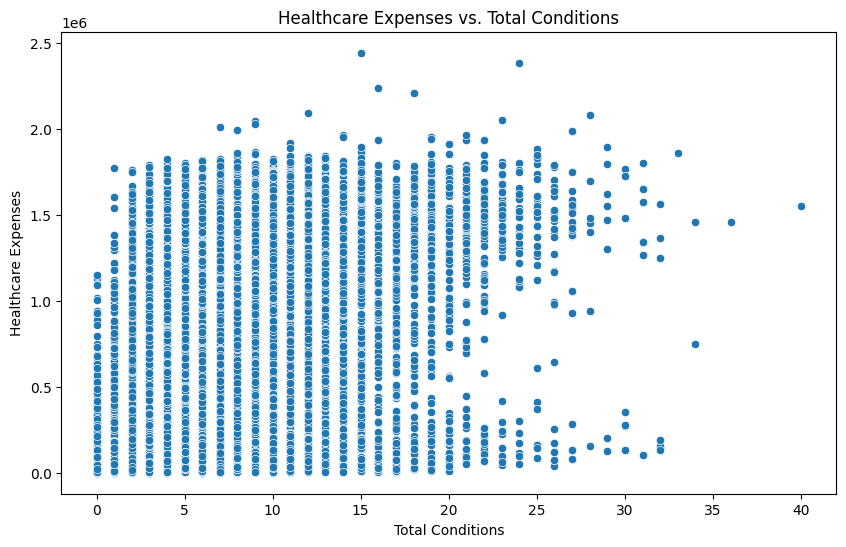

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to examine correlation
plt.figure(figsize=(10,6))
sns.scatterplot(data=finadataframe_s1, x='TOTAL_CONDITIONS', y='HEALTHCARE_EXPENSES')
plt.title('Healthcare Expenses vs. Total Conditions')
plt.xlabel('Total Conditions')
plt.ylabel('Healthcare Expenses')
plt.show()


In [11]:
# Define age bins and labels
bins = [0, 18, 35, 50, 65, float('inf')]  # Example age bins
labels = ['<18', '18-35', '36-50', '51-65', '65+']

# Create AGE_GROUP column
finadataframe_s1['AGE_GROUP'] = pd.cut(finadataframe_s1['AGE'], bins=bins, labels=labels, right=False)



C:\Users\Mahi2\AppData\Local\Temp\ipykernel_21192\2366685509.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_diabetes = finadataframe_s1.groupby('AGE_GROUP')['diabetes_FLAG'].mean()


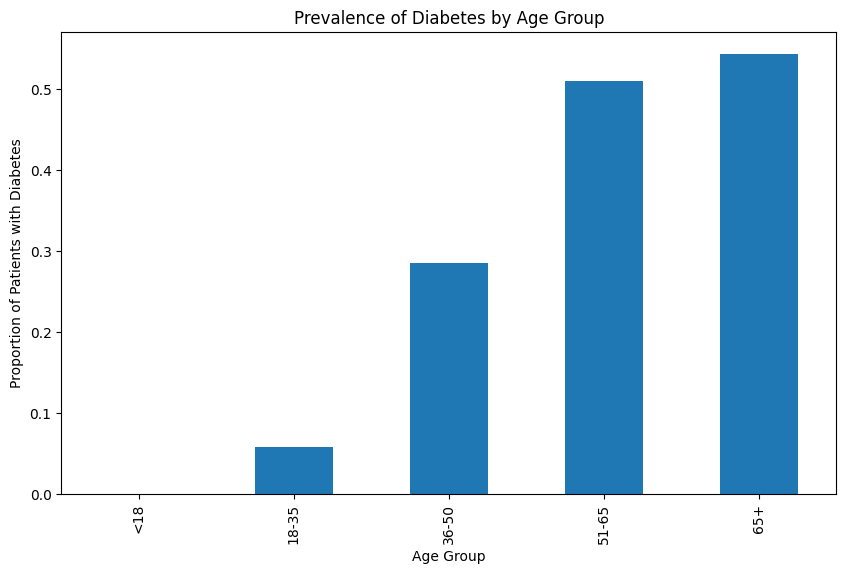

In [12]:
# Plot the prevalence of diabetes by age group
age_group_diabetes = finadataframe_s1.groupby('AGE_GROUP')['diabetes_FLAG'].mean()
age_group_diabetes.plot(kind='bar', figsize=(10,6))
plt.title('Prevalence of Diabetes by Age Group')
plt.ylabel('Proportion of Patients with Diabetes')
plt.xlabel('Age Group')
plt.show()


In [13]:
import pandas as pd

# Percentage of people vaccinated for each vaccine
vaccine_flags = ['FLU_FLAG', 'COVID_FLAG', 'MMR_FLAG', 'TETANUS_FLAG']

vaccine_coverage = finadataframe_s1[vaccine_flags].mean() * 100  # percentage
print("Overall Vaccination Coverage (%):")
print(vaccine_coverage)


Overall Vaccination Coverage (%):
FLU_FLAG        83.288948
COVID_FLAG       0.000000
MMR_FLAG         1.805925
TETANUS_FLAG     3.695073
dtype: float64


C:\Users\Mahi2\AppData\Local\Temp\ipykernel_21192\1734317657.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  finadataframe_s1.groupby(['AGE_GROUP', 'GENDER'])[vaccine_cols]


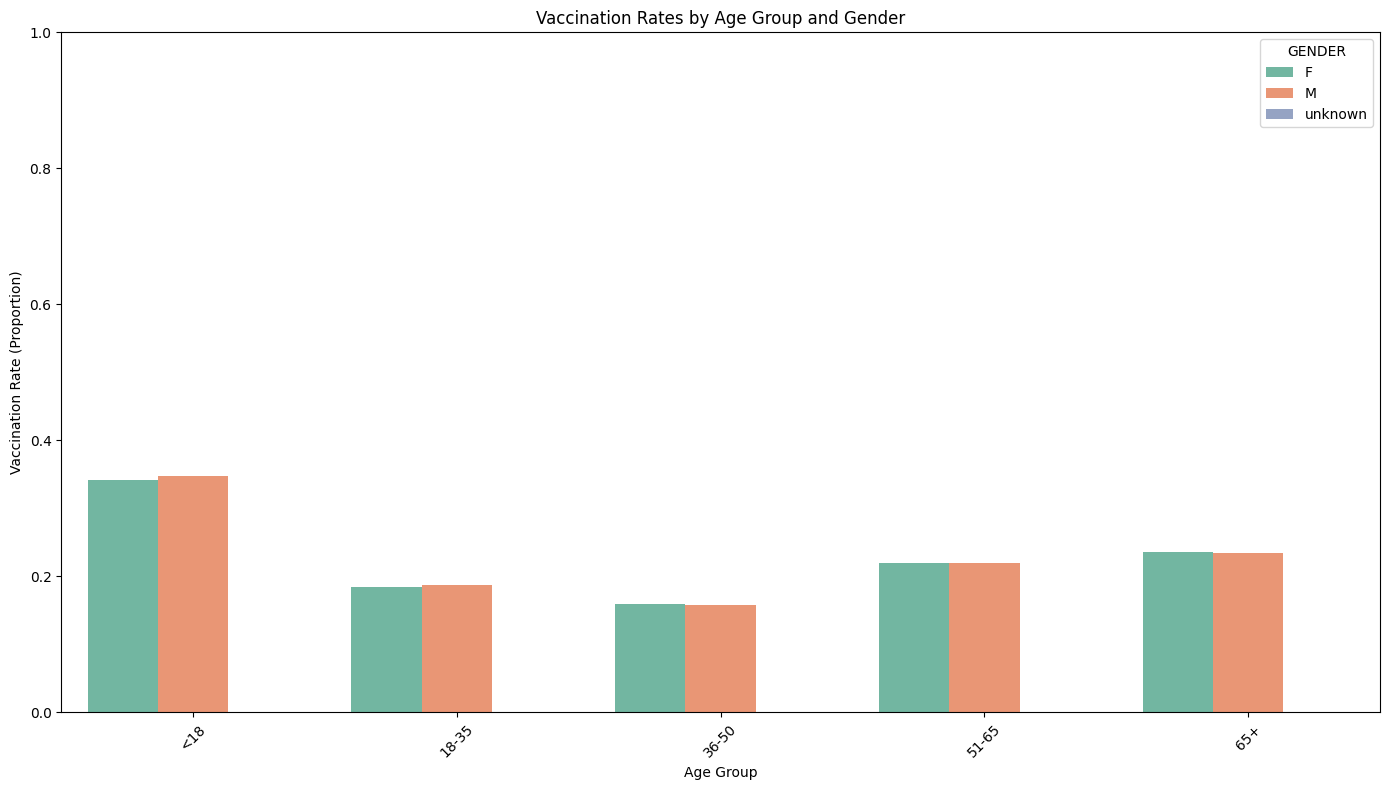

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

vaccine_cols = ['FLU_FLAG', 'COVID_FLAG', 'MMR_FLAG', 'TETANUS_FLAG']

# Compute group averages
vaccine_rates = (
    finadataframe_s1.groupby(['AGE_GROUP', 'GENDER'])[vaccine_cols]
    .mean()
    .reset_index()
)

# Reshape
vaccine_melted = vaccine_rates.melt(
    id_vars=['AGE_GROUP', 'GENDER'],
    value_vars=vaccine_cols,
    var_name='Vaccine',
    value_name='Rate'
)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=vaccine_melted,
    x='AGE_GROUP',
    y='Rate',
    hue='GENDER',
    palette='Set2',
    errorbar=None    # <--- Remove error bars
)

plt.title('Vaccination Rates by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Vaccination Rate (Proportion)')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("vaccine_rates_age_gender.png", dpi=300)
plt.show()


In [14]:
age_cols = [col for col in finadataframe_s1.columns if 'AGE_GROUP' in col]

# Aggregate vaccination rates by age group
age_vaccine = finadataframe_s1.groupby('AGE_GROUP')[vaccine_flags].mean() * 100

print("Vaccination Rates by Age Group (%):")
print(age_vaccine)


Vaccination Rates by Age Group (%):
            FLU_FLAG  COVID_FLAG   MMR_FLAG  TETANUS_FLAG
AGE_GROUP                                                
<18        90.585619         0.0  15.122313     32.320237
18-35      73.901919         0.0   0.255864      0.341151
36-50      63.226453         0.0   0.150301      0.000000
51-65      87.768595         0.0   0.165289      0.000000
65+        93.881208         0.0   0.000000      0.000000


C:\Users\Mahi2\AppData\Local\Temp\ipykernel_21192\2961727882.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_vaccine = finadataframe_s1.groupby('AGE_GROUP')[vaccine_flags].mean() * 100


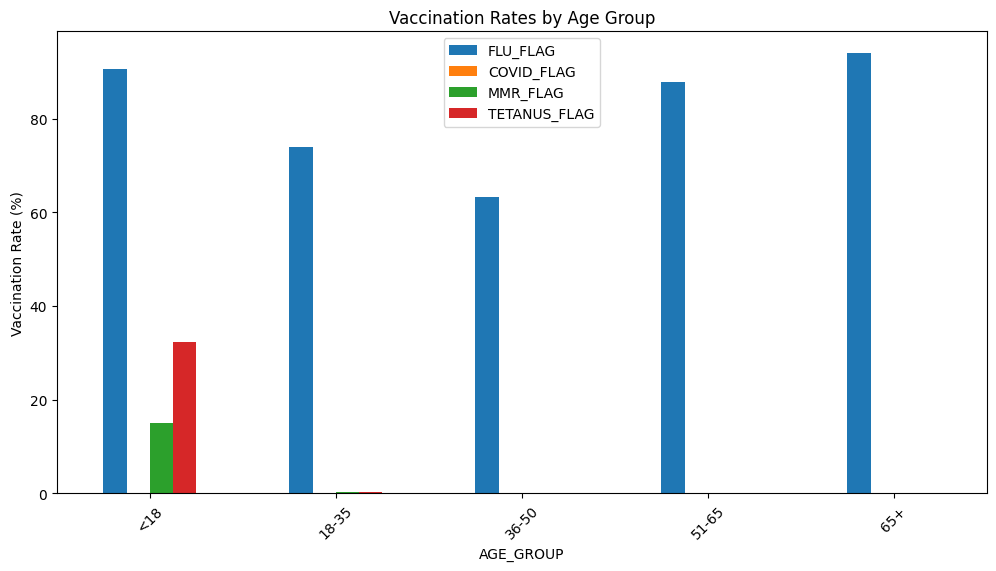

In [15]:
import matplotlib.pyplot as plt

age_vaccine.plot(kind='bar', figsize=(12,6))
plt.ylabel("Vaccination Rate (%)")
plt.title("Vaccination Rates by Age Group")
plt.xticks(rotation=45)
plt.show()


In [17]:
vaccine_cols = ['FLU_FLAG', 'COVID_FLAG', 'MMR_FLAG', 'TETANUS_FLAG']

vaccine_rates = (
    df.groupby(['AGE_GROUP', 'GENDER'])[vaccine_cols]
    .mean()
    .reset_index()
)

print(vaccine_rates.head())


  AGE_GROUP   GENDER  FLU_FLAG  COVID_FLAG  MMR_FLAG  TETANUS_FLAG
0       0-5        F  0.000000         0.0  0.000000      0.378378
1       0-5        M  0.000000         0.0  0.000000      0.312500
2       0-5  unknown       NaN         NaN       NaN           NaN
3      6-17        F  0.941791         0.0  0.162687      0.319403
4      6-17        M  0.944089         0.0  0.151757      0.324281


C:\Users\Mahi2\AppData\Local\Temp\ipykernel_21192\2558359428.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['AGE_GROUP', 'GENDER'])[vaccine_cols]


In [ ]:
# Melt the dataframe for seaborn plotting
vaccine_melt = vaccine_rates.melt(id_vars=['AGE_GROUP', 'GENDER'],
                                  value_vars=vaccine_cols,
                                  var_name='Vaccine',
                                  value_name='Vaccination_Rate')

plt.figure(figsize=(10, 6))
sns.barplot(data=vaccine_melt, x='AGE_GROUP', y='Vaccination_Rate', hue='GENDER')
plt.title('Vaccination Rates by Age Group and Gender')
plt.ylabel('Proportion Vaccinated')
plt.xlabel('Age Group')
plt.legend(title='Gender')
plt.show()


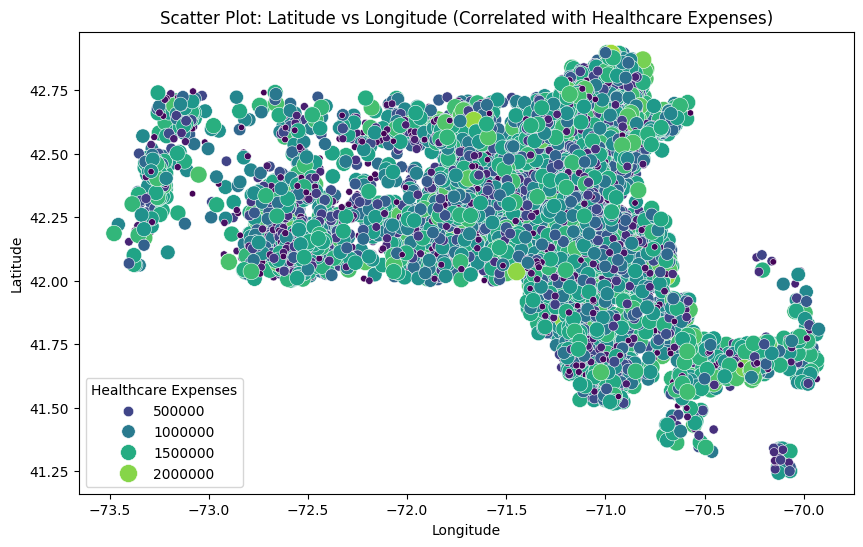

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'finadataframe_s1' has columns: 'lat', 'lon', 'healthcare_expenses'

# Scatter plot of latitude vs longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=finadataframe_s1, x='LON', y='LAT', hue='HEALTHCARE_EXPENSES', palette='viridis', size='HEALTHCARE_EXPENSES', sizes=(20, 200))
plt.title('Scatter Plot: Latitude vs Longitude (Correlated with Healthcare Expenses)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Healthcare Expenses')
plt.show()


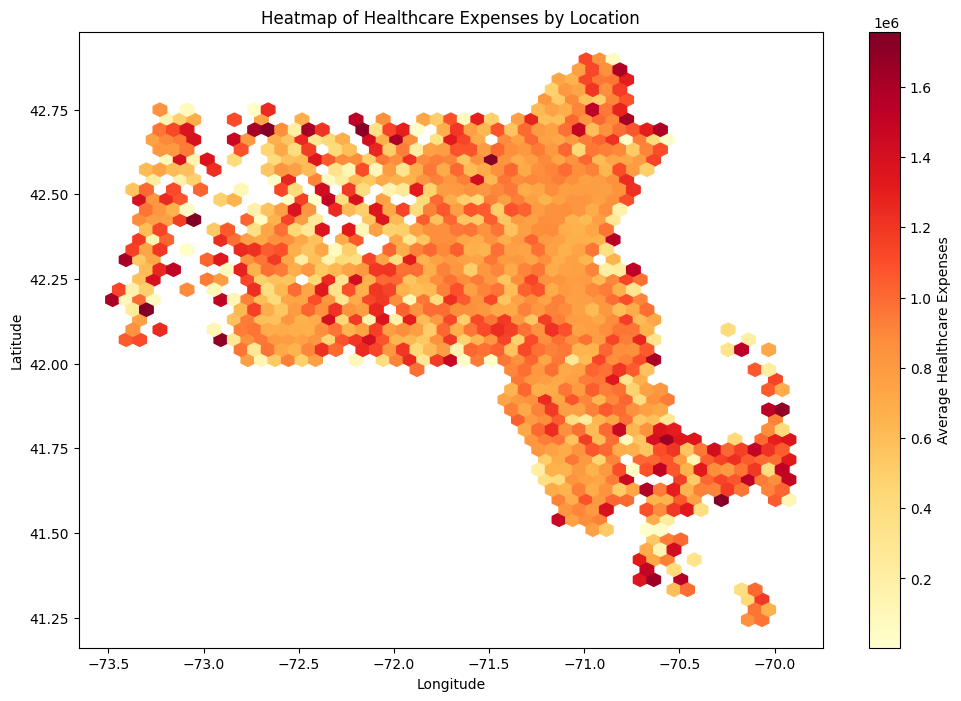

In [38]:
import matplotlib.pyplot as plt
import numpy as np  # Needed for np.mean

plt.figure(figsize=(12, 8))

# Corrected hexbin heatmap
hb = plt.hexbin(
    finadataframe_s1['LON'],                # x-axis: Longitude
    finadataframe_s1['LAT'],                # y-axis: Latitude
    C=finadataframe_s1['HEALTHCARE_EXPENSES'],  # values for color intensity
    gridsize=50,                            # adjust for resolution
    cmap='YlOrRd',                          # color map
    reduce_C_function=np.mean               # use numpy's mean function
)

plt.colorbar(hb, label='Average Healthcare Expenses')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Healthcare Expenses by Location')
plt.show()


In [44]:
!pip install --upgrade pip
!pip install geopy
!pip install folium


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\Mahi2\capstone\capstone_healthpredictors\venv\Scripts\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached xyzservices-2025.11.0-py3-none-any.whl.metadata (4.3 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.2-py3-none-any.whl (26 kB)
Using cached xyzservices-2025.11.0-py3-none-any.whl (93 kB)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
!python -m pip install --upgrade pip


  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapi")

def get_county(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        address = location.raw['address']
        return address.get('county', None)
    except:
        return None

# Apply to your dataframe
finadataframe_s1['COUNTY'] = finadataframe_s1.apply(lambda row: get_county(row['LAT'], row['LON']), axis=1)
